In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import os
import string
from tqdm import tqdm
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as pyplt

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing
from sklearn.preprocessing import Normalizer

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn.metrics import f1_score, roc_curve, auc, roc_auc_score

from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV

In [2]:
# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

#filtering only positive and negative review
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 

#mapping positive and negative review
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be negative and more than 3 to be positive.
score = filtered_data['Score']
positiveNegative = score.map(partition) 
filtered_data['Score'] = positiveNegative
filtered_data.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [4]:
#Sorting according to ProductId 
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [5]:
#removing duplicate
final_df = sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final_df.shape

(364173, 10)

In [6]:
#percentage of data remain after removing duplicate data
(final_df['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

In [7]:
# data cleaning
final_df = final_df[final_df.HelpfulnessNumerator<=final_df.HelpfulnessDenominator]

In [8]:
print(final_df.shape)
#No of reviews left for each class
final_df['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

In [9]:

nltk.download('stopwords')

stopwords = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #to remove html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

def cleanpunc(sentence): #to clean punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

[nltk_data] Downloading package stopwords to /home/dharma/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
#pre-processing phase, as it process whole dataset, it will take some time

if not os.path.isfile('final.sqlite'):
    final_string=[]
    positive_words=[] 
    negative_words=[] 
    
    for i, sent in enumerate(tqdm(final_df['Text'].values)):
        filtered_sentence=[]
        sent=cleanhtml(sent) # remove HTMl tags
        
        for w in sent.split():
            # we have used cleanpunc(w).split(), one more split function here because consider w="abc.def", cleanpunc(w) will return "abc def"
            # if we dont use .split() function then we will be considring "abc def" as a single word, but if you use .split() function we will get "abc", "def"
            for cleaned_words in cleanpunc(w).split():
                if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                    if(cleaned_words.lower() not in stopwords):
                        s=(sno.stem(cleaned_words.lower())).encode('utf8')
                        filtered_sentence.append(s)
                        if (final_df['Score'].values)[i] == 1: 
                            positive_words.append(s) 
                        if(final_df['Score'].values)[i] == 0:
                            negative_words.append(s) 
        
        str1 = b" ".join(filtered_sentence) #final string of cleaned words
        final_string.append(str1)

    #storing the data into .sqlite file 
    final_df['CleanedText'] = final_string #adding a column of CleanedText 
    final_df['CleanedText'] = final_df['CleanedText'].str.decode("utf-8")
    
    #store final table into an SQlLite table for future.
    conn = sqlite3.connect('final.sqlite')
    c=conn.cursor()
    conn.text_factory = str
    final_df.to_sql('Reviews', conn,  schema=None, if_exists='replace', \
                 index=True, index_label=None, chunksize=None, dtype=None)
    conn.close()
    


In [11]:
if os.path.isfile('final.sqlite'):
    conn = sqlite3.connect('final.sqlite')
    final_df = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, conn)
    conn.close()

In [12]:
# sorting dataframe based on time
final_df = final_df.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
final_df.shape

(364171, 12)

In [13]:
X = final_df['CleanedText']
Y = final_df['Score']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.80, random_state=0)
X_train, X_cv, Y_train, Y_cv = train_test_split(X_train, Y_train, test_size=.50, random_state=0)
#to reduce the percentage of test data, as we have less computing power
X_test, X_rest, Y_test, Y_rest = train_test_split(X_test, Y_test, test_size=.90, random_state=0)

In [14]:
#BoW
count_vect = CountVectorizer()
bow_train = count_vect.fit_transform(X_train)
bow_cv = count_vect.transform(X_cv)
bow_test = count_vect.transform(X_test)

In [15]:
#Normalize bow vectorized Data
bow_train = preprocessing.normalize(bow_train)
bow_cv = preprocessing.normalize(bow_cv)
bow_test = preprocessing.normalize(bow_test)

In [16]:
# bigram tfidf vectorizer 
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
tfidf_train = tf_idf_vect.fit_transform(X_train)
tfidf_cv = tf_idf_vect.transform(X_cv)
tfidf_test = tf_idf_vect.transform(X_test)

In [17]:
#Normalize tfidf vectorized Data
tfidf_train = preprocessing.normalize(tfidf_train)
tfidf_cv = preprocessing.normalize(tfidf_cv)
tfidf_test = preprocessing.normalize(tfidf_test)

In [18]:
print(tfidf_train.shape)
print(Y_train.shape)
print(tfidf_cv.shape)
print(Y_cv.shape)
print(tfidf_test.shape)
print(Y_test.shape)

(36417, 617879)
(36417,)
(36417, 617879)
(36417,)
(29133, 617879)
(29133,)


In [19]:
# SVM with penality = 'l1'
def Sgd_Classifier(X_train, X_cv, Y_train, Y_cv):
    optimal_alpha=0
    max_roc_auc=-1
    pred_cv = []
    pred_train = []
    alpha = [10 ** x for x in range(-3, 3)]
    for i in tqdm(alpha):
        clf = SGDClassifier(alpha=i, penalty='l2', loss='hinge', random_state=42)
        clf.fit(X_train,Y_train)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(X_train, Y_train)
        probs = sig_clf.predict_proba(X_cv)
        prob = sig_clf.predict_proba(X_train)
        
        probs = probs[:,1]
        prob = prob[:,1]
        
        auc_score_cv = roc_auc_score(Y_cv,probs)
        auc_score_train = roc_auc_score(Y_train,prob)

        pred_cv.append(auc_score_cv)
        pred_train.append(auc_score_train)
        if(max_roc_auc<auc_score_cv):
            max_roc_auc=auc_score_cv
            optimal_alpha=i
            
    sns.set_style("darkgrid")
    plt.xscale('log')
    plt.plot(alpha, pred_cv,'r-', label = 'CV Data')
    plt.plot(alpha,pred_train,'g-', label ='Train Data')
    plt.legend(loc='upper right')
    plt.title(r'Auc Score v/s $\alpha$')
    plt.xlabel(r"alpha values",fontsize=12)
    plt.ylabel("roc_auc",fontsize=12)
    plt.show()
    
    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(Y_train,prob)
    # plot no skill
    pyplt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    pyplt.plot(fpr, tpr, marker='.')
    pyplt.title("Line Plot of ROC Curve on Train Data")
    pyplt.ylabel('True Positive Rate')
    pyplt.xlabel('False Positive Rate')
    pyplt.show()    

In [20]:

def testing(X_train,Y_train,X_test,Y_test,optimal_alpha):
    clf = SGDClassifier(alpha=optimal_alpha, penalty='l2', loss='hinge', random_state=42)
    clf.fit(X_train,Y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, Y_train)
    prob = sig_clf.predict_proba(X_test) 
    
    # keep probabilities for the positive outcome only
    probs = prob[:, 1]
    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(Y_test,probs)
    
    # plot no skill
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.plot(fpr, tpr, marker='.')
    plt.title("Line Plot of ROC Curve on Test Data")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')    
    plt.show
    
    prediction = np.argmax(prob,axis=1)
    print("AUC Score", roc_auc_score(Y_test,probs))
    print("macro f1 score:", metrics.f1_score(Y_test, prediction, average = 'macro'))
    print("micro f1 score:", metrics.f1_score(Y_test, prediction, average = 'micro'))
    print("Precision recall report:\n", metrics.classification_report(Y_test, prediction))

100%|██████████| 6/6 [00:20<00:00,  3.35s/it]


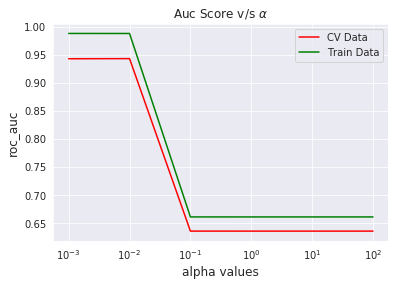

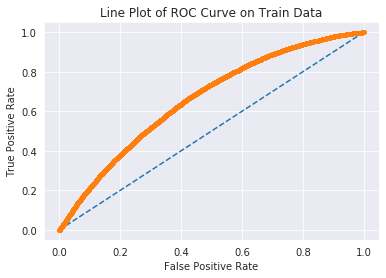

In [21]:
# find optimal_C using l1 regularization
Sgd_Classifier(tfidf_train, tfidf_cv, Y_train, Y_cv)

AUC Score 0.9430110124913239
macro f1 score: 0.8339447799288928
micro f1 score: 0.9184773281158825
Precision recall report:
               precision    recall  f1-score   support

           0       0.80      0.65      0.72      4594
           1       0.94      0.97      0.95     24539

    accuracy                           0.92     29133
   macro avg       0.87      0.81      0.83     29133
weighted avg       0.91      0.92      0.92     29133



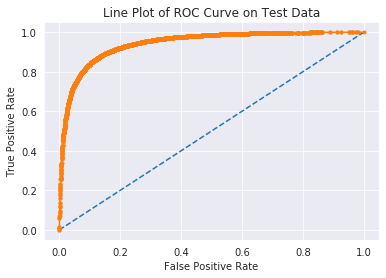

In [24]:
# optimal_C=5 for l1 regularization
testing(tfidf_train, Y_train, tfidf_test, Y_test, optimal_alpha=0.001 )